In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import seaborn as sns
import os
import shutil
import pickle
import re
import time
import sys
import pdb
import pandas as pd
from scipy.stats import poisson
from scipy.stats import norm

sns.set()

In [2]:
def perfect_SN(data_dict):
    
    high_noise = []
    high_flux = []
    high_wave = []
    high_ivar = []
    high_redshift = []
    high_class = []
    
    
    for i in range(len(data_dict['CLASS'])):
        
        if data_dict['NOISE'][i] >= 20.:
            
            high_noise.append(data_dict['NOISE'][i])
            high_flux.append(data_dict['FLUX'][i])
            high_wave.append(data_dict['WAVE'][i])
            high_ivar.append(data_dict['IVAR'][i])
            high_redshift.append(data_dict['REDSHIFT'][i])
            high_class.append(data_dict['CLASS'][i])
            
        else:
            pass
        
    
    highSN_dict = {'NOISE': high_noise, 'FLUX': high_flux, 'WAVE': high_wave, 'IVAR': high_ivar,\
                   'REDSHIFT': high_redshift, 'CLASS': high_class}
    
    return highSN_dict 



def noise_model(data_dict, seed, override_val):
    
    ivar = data_dict['IVAR']
    flux = data_dict['FLUX']
    noise = data_dict['NOISE']
    
    noisy_flux = []
    deviate = []
    new_noise = []
    
    for i in range(len(ivar)):
        
        var = (1/ivar[i])
        new_var = np.nan_to_num(var, posinf=0, neginf=0, nan=0)
        new_std = new_var ** 0.5
        
        if noise[i] <= 32:
            
            gaussian_deviate = norm.rvs(size = len(ivar[i]), scale = 8*new_std, loc = 0, random_state = seed)
        
            flux_w_noise = flux[i] + gaussian_deviate
        
            deviate.append(gaussian_deviate)
            noisy_flux.append(flux_w_noise)
            
        elif noise[i] > 32:
            
            gaussian_deviate = norm.rvs(size = len(ivar[i]), scale = 16*new_std, loc = 0, random_state = seed)
        
            flux_w_noise = flux[i] + gaussian_deviate
        
            deviate.append(gaussian_deviate)
            noisy_flux.append(flux_w_noise)
            
        
        
    new_dict = {'VAR': new_var, 'IVAR': data_dict['IVAR'], 'CLASS': data_dict['CLASS'], 'WAVE': data_dict['WAVE'],\
               'REDSHIFT': data_dict['REDSHIFT'], 'FLUX': noisy_flux, 'DEVIATE': deviate, 'NOISE': data_dict['NOISE']}
            
        
    return new_dict



def merg_dict(dict1, dict2, dict3, dict4, dict5, dict6, dict7, dict8, dict9, dict10, dict11, dict12, dict13, dict14,\
             dict15, dict16, dict17, dict18, dict19, dict20, dict21, dict22, dict23, dict24, dict25):
    """This code merges dictionaries together that all have the same keys and assigns them to a new dictionary"""
    
    dict_list = [dict1, dict2, dict3, dict4, dict5, dict6, dict7, dict8,  dict9, dict10, dict11, dict12, dict13,\
                 dict14, dict15, dict16, dict17, dict18, dict19, dict20, dict21, dict22, dict23, dict24, dict25]
    merged_dict = {}
    for k in dict1.keys():
        merged_dict[k] = np.concatenate(list(merged_dict[k] for merged_dict in dict_list))
        
    return merged_dict



def calc_model_noise(merg_dict):
    """
    Code calculates the changed noise via the noise model
    """
        
    labels = merg_dict['CLASS']
    new_noise = []
    
    for i in range(len(labels)):
    
        if labels[i] == 'QSO':
        
            new_noise.append(np.mean(merg_dict['FLUX'][i])\
                     /(np.std(merg_dict['FLUX'][i])))      
            
    merg_dict['FAKE_NOISE'] = new_noise
    
    
    return merg_dict

def balancing_noise(calc_merg_dict, var_dict, added_val):
    """
    Code to balance the noise distributions between the noise model data and the variable quasar data
    """
    
    var_noise = np.asarray(var_dict['NOISE'])
    var_labels = np.asarray(var_dict['CLASS'])
    arr_indx = np.where(var_labels == 'QSO')
    quasar_noise = var_noise[arr_indx]
    
    indx0 = np.where((quasar_noise >= 0.0) & (quasar_noise < 0.2))
    indx1 = np.where((quasar_noise >= 0.2) & (quasar_noise < 0.4))
    indx2 = np.where((quasar_noise >= 0.4) & (quasar_noise < 0.6))
    indx3 = np.where((quasar_noise >= 0.6) & (quasar_noise < 0.8))
    indx4 = np.where((quasar_noise >= 0.8) & (quasar_noise < 1.0))
    indx5 = np.where((quasar_noise >= 1.0) & (quasar_noise < 1.2))
    indx6 = np.where((quasar_noise >= 1.2) & (quasar_noise < 1.4))
    indx7 = np.where((quasar_noise >= 1.4) & (quasar_noise < 1.6))
    indx8 = np.where((quasar_noise >= 1.6) & (quasar_noise < 1.8))
    indx9 = np.where((quasar_noise >= 1.8) & (quasar_noise <= 2.0))

    qso_noise0 = quasar_noise[indx0]
    qso_noise1 = quasar_noise[indx1]
    qso_noise2 = quasar_noise[indx2]
    qso_noise3 = quasar_noise[indx3]
    qso_noise4 = quasar_noise[indx4]
    qso_noise5 = quasar_noise[indx5]
    qso_noise6 = quasar_noise[indx6]
    qso_noise7 = quasar_noise[indx7]
    qso_noise8 = quasar_noise[indx8]
    qso_noise9 = quasar_noise[indx9]
    
    new_noise = np.asarray(calc_merg_dict['FAKE_NOISE'])
    new_norm_noise = np.asarray(calc_merg_dict['NOISE'])
    new_wave = np.asarray(calc_merg_dict['WAVE'])
    new_redshift = np.asarray(calc_merg_dict['REDSHIFT'])
    new_flux = np.asarray(calc_merg_dict['FLUX'])
    new_class = np.asarray(calc_merg_dict['CLASS'])

    fake_indx0 = np.where((new_noise >= 0.0) & (new_noise < 0.2))
    fake_indx1 = np.where((new_noise >= 0.2) & (new_noise < 0.4))
    fake_indx2 = np.where((new_noise >= 0.4) & (new_noise < 0.6))
    fake_indx3 = np.where((new_noise >= 0.6) & (new_noise < 0.8))
    fake_indx4 = np.where((new_noise >= 0.8) & (new_noise < 1.0))
    fake_indx5 = np.where((new_noise >= 1.0) & (new_noise < 1.2))
    fake_indx6 = np.where((new_noise >= 1.2) & (new_noise < 1.4))
    fake_indx7 = np.where((new_noise >= 1.4) & (new_noise < 1.6))
    fake_indx8 = np.where((new_noise >= 1.6) & (new_noise < 1.8))
    fake_indx9 = np.where((new_noise >= 1.8) & (new_noise <= 2.0))
    
    new_noise0 = new_noise[fake_indx0]
    new_noise1 = new_noise[fake_indx1]
    new_noise2 = new_noise[fake_indx2]
    new_noise3 = new_noise[fake_indx3]
    new_noise4 = new_noise[fake_indx4]
    new_noise5 = new_noise[fake_indx5]
    new_noise6 = new_noise[fake_indx6]
    new_noise7 = new_noise[fake_indx7]
    new_noise8 = new_noise[fake_indx8]
    new_noise9 = new_noise[fake_indx9]
    
    new_norm_noise0 = new_norm_noise[fake_indx0]
    new_norm_noise1 = new_norm_noise[fake_indx1]
    new_norm_noise2 = new_norm_noise[fake_indx2]
    new_norm_noise3 = new_norm_noise[fake_indx3]
    new_norm_noise4 = new_norm_noise[fake_indx4]
    new_norm_noise5 = new_norm_noise[fake_indx5]
    new_norm_noise6 = new_norm_noise[fake_indx6]
    new_norm_noise7 = new_norm_noise[fake_indx7]
    new_norm_noise8 = new_norm_noise[fake_indx8]
    new_norm_noise9 = new_norm_noise[fake_indx9]
    
    new_wave0 = new_wave[fake_indx0]
    new_wave1 = new_wave[fake_indx1]
    new_wave2 = new_wave[fake_indx2]
    new_wave3 = new_wave[fake_indx3]
    new_wave4 = new_wave[fake_indx4]
    new_wave5 = new_wave[fake_indx5]
    new_wave6 = new_wave[fake_indx6]
    new_wave7 = new_wave[fake_indx7]
    new_wave8 = new_wave[fake_indx8]
    new_wave9 = new_wave[fake_indx9]
    
    new_redshift0 = new_redshift[fake_indx0]
    new_redshift1 = new_redshift[fake_indx1]
    new_redshift2 = new_redshift[fake_indx2]
    new_redshift3 = new_redshift[fake_indx3]
    new_redshift4 = new_redshift[fake_indx4]
    new_redshift5 = new_redshift[fake_indx5]
    new_redshift6 = new_redshift[fake_indx6]
    new_redshift7 = new_redshift[fake_indx7]
    new_redshift8 = new_redshift[fake_indx8]
    new_redshift9 = new_redshift[fake_indx9]
    
    new_flux0 = new_flux[fake_indx0]
    new_flux1 = new_flux[fake_indx1]
    new_flux2 = new_flux[fake_indx2]
    new_flux3 = new_flux[fake_indx3]
    new_flux4 = new_flux[fake_indx4]
    new_flux5 = new_flux[fake_indx5]
    new_flux6 = new_flux[fake_indx6]
    new_flux7 = new_flux[fake_indx7]
    new_flux8 = new_flux[fake_indx8]
    new_flux9 = new_flux[fake_indx9] 
    
    new_class0 = new_class[fake_indx0]
    new_class1 = new_class[fake_indx1]
    new_class2 = new_class[fake_indx2]
    new_class3 = new_class[fake_indx3]
    new_class4 = new_class[fake_indx4]
    new_class5 = new_class[fake_indx5]
    new_class6 = new_class[fake_indx6]
    new_class7 = new_class[fake_indx7]
    new_class8 = new_class[fake_indx8]
    new_class9 = new_class[fake_indx9]
    
    noise_cut = []
    wave_cut = []
    flux_cut = []
    class_cut = []
    redshift_cut = []
    fake_noise_cut = []
    
    if (len(qso_noise0)) < (len(new_noise0)):
        # 
        cut_noise0 = new_norm_noise0[:len(qso_noise0) + added_val]
        noise_cut.append(cut_noise0)
        
        cut_wave0 = new_wave0[:len(qso_noise0) + added_val]
        wave_cut.append(cut_wave0)
        
        cut_flux0 = new_flux0[:len(qso_noise0) + added_val]
        flux_cut.append(cut_flux0)
        
        cut_class0 = new_class0[:len(qso_noise0) + added_val]
        class_cut.append(cut_class0)
        
        cut_redshift0 = new_redshift0[:len(qso_noise0) + added_val]
        redshift_cut.append(cut_redshift0)
        
        cut_fake_noise0 = new_noise0[:len(qso_noise0) + added_val]
        fake_noise_cut.append(cut_fake_noise0)
        
    if (len(qso_noise1)) < (len(new_noise1)):
        
        cut_noise1 = new_norm_noise1[:len(qso_noise1) + added_val]
        noise_cut.append(cut_noise1)
        
        cut_wave1 = new_wave1[:len(qso_noise1) + added_val]
        wave_cut.append(cut_wave1)
        
        cut_flux1 = new_flux1[:len(qso_noise1) + added_val]
        flux_cut.append(cut_flux1)
        
        cut_class1 = new_class1[:len(qso_noise1) + added_val]
        class_cut.append(cut_class1)
        
        cut_redshift1 = new_redshift1[:len(qso_noise1) + added_val]
        redshift_cut.append(cut_redshift1)
        
        cut_fake_noise1 = new_noise1[:len(qso_noise1) + added_val]
        fake_noise_cut.append(cut_fake_noise1)
        
    if (len(qso_noise2)) < (len(new_noise2)):
        
        cut_noise2 = new_norm_noise2[:len(qso_noise2) + added_val]
        noise_cut.append(cut_noise2)
        
        cut_wave2 = new_wave2[:len(qso_noise2) + added_val]
        wave_cut.append(cut_wave2)
        
        cut_flux2 = new_flux2[:len(qso_noise2) + added_val]
        flux_cut.append(cut_flux2)
        
        cut_class2 = new_class2[:len(qso_noise2) + added_val]
        class_cut.append(cut_class2)
        
        cut_redshift2 = new_redshift2[:len(qso_noise2) + added_val]
        redshift_cut.append(cut_redshift2)
        
        cut_fake_noise2 = new_noise2[:len(qso_noise2) + added_val]
        fake_noise_cut.append(cut_fake_noise2)
        
    if (len(qso_noise3)) < (len(new_noise3)):
        
        cut_noise3 = new_norm_noise3[:len(qso_noise3) + added_val]
        noise_cut.append(cut_noise3)
        
        cut_wave3 = new_wave3[:len(qso_noise3) + added_val]
        wave_cut.append(cut_wave3)
        
        cut_flux3 = new_flux3[:len(qso_noise3) + added_val]
        flux_cut.append(cut_flux3)
        
        cut_class3 = new_class3[:len(qso_noise3) + added_val]
        class_cut.append(cut_class3)
        
        cut_redshift3 = new_redshift3[:len(qso_noise3) + added_val]
        redshift_cut.append(cut_redshift3)
        
        cut_fake_noise3 = new_noise3[:len(qso_noise3) + added_val]
        fake_noise_cut.append(cut_fake_noise3)
        
    if (len(qso_noise4)) < (len(new_noise4)):
        
        cut_noise4 = new_norm_noise4[:len(qso_noise4) + added_val]
        noise_cut.append(cut_noise4)
        
        cut_wave4 = new_wave4[:len(qso_noise4) + added_val]
        wave_cut.append(cut_wave4)
        
        cut_flux4 = new_flux4[:len(qso_noise4) + added_val]
        flux_cut.append(cut_flux4)
        
        cut_class4 = new_class4[:len(qso_noise4) + added_val]
        class_cut.append(cut_class4)
        
        cut_redshift4 = new_redshift4[:len(qso_noise4) + added_val]
        redshift_cut.append(cut_redshift4)
        
        cut_fake_noise4 = new_noise4[:len(qso_noise4) + added_val]
        fake_noise_cut.append(cut_fake_noise4)
    
        
    if (len(qso_noise5)) < (len(new_noise5)):
        
        cut_noise5 = new_norm_noise5[:len(qso_noise5) + added_val]
        noise_cut.append(cut_noise5)
        
        cut_wave5 = new_wave5[:len(qso_noise5) + added_val]
        wave_cut.append(cut_wave5)
        
        cut_flux5 = new_flux5[:len(qso_noise5) + added_val]
        flux_cut.append(cut_flux5)
        
        cut_class5 = new_class5[:len(qso_noise5) + added_val]
        class_cut.append(cut_class5)
        
        cut_redshift5 = new_redshift5[:len(qso_noise5) + added_val]
        redshift_cut.append(cut_redshift5)
        
        cut_fake_noise5 = new_noise5[:len(qso_noise5) + added_val]
        fake_noise_cut.append(cut_fake_noise5)
           
    if (len(qso_noise6)) < (len(new_noise6)):
        
        cut_noise6 = new_norm_noise6[:len(qso_noise6) + added_val]
        noise_cut.append(cut_noise6)
        
        cut_wave6 = new_wave6[:len(qso_noise6) + added_val]
        wave_cut.append(cut_wave6)
        
        cut_flux6 = new_flux6[:len(qso_noise6) + added_val]
        flux_cut.append(cut_flux6)
        
        cut_class6 = new_class6[:len(qso_noise6) + added_val]
        class_cut.append(cut_class6)
        
        cut_redshift6 = new_redshift6[:len(qso_noise6) + added_val]
        redshift_cut.append(cut_redshift6)
        
        cut_fake_noise6 = new_noise6[:len(qso_noise6) + added_val]
        fake_noise_cut.append(cut_fake_noise6)
        
    if (len(qso_noise7)) < (len(new_noise7)):
        
        cut_noise7 = new_norm_noise7[:len(qso_noise7) + added_val]
        noise_cut.append(cut_noise7)
        
        cut_wave7 = new_wave7[:len(qso_noise7) + added_val]
        wave_cut.append(cut_wave7)
        
        cut_flux7 = new_flux7[:len(qso_noise7) + added_val]
        flux_cut.append(cut_flux7)
        
        cut_class7 = new_class7[:len(qso_noise7) + added_val]
        class_cut.append(cut_class7)
        
        cut_redshift7 = new_redshift7[:len(qso_noise7) + added_val]
        redshift_cut.append(cut_redshift7)
        
        cut_fake_noise7 = new_noise7[:len(qso_noise7) + added_val]
        fake_noise_cut.append(cut_fake_noise7)

    if (len(qso_noise8)) < (len(new_noise8)):
        
        cut_noise8 = new_norm_noise8[:len(qso_noise8) + added_val]
        noise_cut.append(cut_noise8)
        
        cut_wave8 = new_wave8[:len(qso_noise8) + added_val]
        wave_cut.append(cut_wave8)
        
        cut_flux8 = new_flux8[:len(qso_noise8) + added_val]
        flux_cut.append(cut_flux8)
        
        cut_class8 = new_class8[:len(qso_noise8) + added_val]
        class_cut.append(cut_class8)
        
        cut_redshift8 = new_redshift8[:len(qso_noise8) + added_val]
        redshift_cut.append(cut_redshift8)
        
        cut_fake_noise8 = new_noise8[:len(qso_noise8) + added_val]
        fake_noise_cut.append(cut_fake_noise8)

    if (len(qso_noise9)) < (len(new_noise9)):
        
        cut_noise9 = new_norm_noise9[:len(qso_noise9) + added_val]
        noise_cut.append(cut_noise9)
        
        cut_wave9 = new_wave9[:len(qso_noise9) + added_val]
        wave_cut.append(cut_wave9)
        
        cut_flux9 = new_flux9[:len(qso_noise9) + added_val]
        flux_cut.append(cut_flux9)
        
        cut_class9 = new_class9[:len(qso_noise9) + added_val]
        class_cut.append(cut_class9)
        
        cut_redshift9 = new_redshift9[:len(qso_noise9) + added_val]
        redshift_cut.append(cut_redshift9)
        
        cut_fake_noise9 = new_noise9[:len(qso_noise9) + added_val]
        fake_noise_cut.append(cut_fake_noise9)


    noise = np.concatenate([np.array(i) for i in noise_cut])
    wave = np.concatenate([np.array(i) for i in wave_cut])
    flux = np.concatenate([np.array(i) for i in flux_cut])
    classifier = np.concatenate([np.array(i) for i in class_cut])
    redshift = np.concatenate([np.array(i) for i in redshift_cut])
    fake_noise = np.concatenate([np.array(i) for i in fake_noise_cut])
    
    
    noise_cut_dict = {'NOISE': noise, 'WAVE': wave,\
                      'FLUX': flux, 'CLASS': classifier,\
                      'REDSHIFT': redshift, 'FAKE_NOISE': fake_noise}

    
    return noise_cut_dict


    
    
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

In [3]:
high_dict = pd.read_pickle("/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/object_dict/high_SN_quasar_dict")

var_star_dict = pd.read_pickle("/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/joined_obj_dicts/varstar_dict")

star_dict = pd.read_pickle("/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/object_dict/star_dict")


var_star_dict.keys()


dict_keys(['HIGH', 'LOW'])

In [4]:
high_dict.keys()

dict_keys(['FLUX', 'CLASS', 'NOISE', 'WAVE', 'REDSHIFT', 'PLATE', 'MJD', 'FIBER', 'PSFMAG', 'R', 'G', 'EBOSS_TARGET1', 'RA', 'DEC', 'IVAR'])

In [5]:
star_dict.keys()

dict_keys(['FLUX', 'CLASS', 'NOISE', 'WAVE', 'REDSHIFT', 'PLATE', 'MJD', 'FIBER', 'PSFMAG', 'R', 'G', 'RA', 'DEC', 'IVAR'])

In [6]:
perfectSN_dict = perfect_SN(high_dict)
ivar = np.asarray(perfectSN_dict['IVAR'])
flux = np.asarray(perfectSN_dict['FLUX'])
labels = np.asarray(perfectSN_dict['CLASS'])
wave = np.asarray(perfectSN_dict['WAVE'])
redshift = np.asarray(perfectSN_dict['REDSHIFT'])


#star_perfSN_dict = perfect_SN(star_dict)
#star_ivar = np.asarray(perfectSN_dict['IVAR'])
# star_flux = np.asarray(perfectSN_dict['FLUX'])
# star_labels = np.asarray(perfectSN_dict['CLASS'])
# star_wave = np.asarray(perfectSN_dict['WAVE'])
# star_redshift = np.asarray(perfectSN_dict['REDSHIFT'])

Text(0, 0.5, 'I dont know the units')

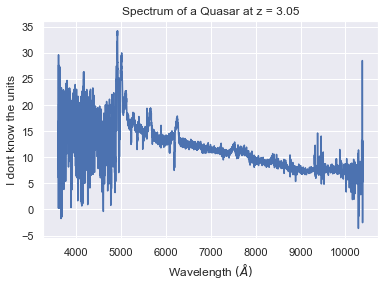

In [7]:
plt.plot(10**perfectSN_dict['WAVE'][364], perfectSN_dict['FLUX'][364])
plt.title('Spectrum of a Quasar at z = 3.05')
plt.xlabel('Wavelength $(\AA)$')
plt.ylabel('I dont know the units')


Text(0, 0.5, 'I dont know the units')

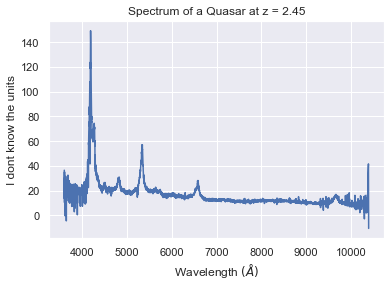

In [8]:
plt.plot(10**perfectSN_dict['WAVE'][649], perfectSN_dict['FLUX'][649])
plt.title('Spectrum of a Quasar at z = 2.45')
plt.xlabel('Wavelength $(\AA)$')
plt.ylabel('I dont know the units')

In [9]:
perfectSN_dict.keys()

dict_keys(['NOISE', 'FLUX', 'WAVE', 'IVAR', 'REDSHIFT', 'CLASS'])

In [10]:
x0 = noise_model(perfectSN_dict, 0, 0.0)
x1 = noise_model(perfectSN_dict, 1, 0.0)
x2 = noise_model(perfectSN_dict, 2, 0.0)
x3 = noise_model(perfectSN_dict, 3, 0.0)
x4 = noise_model(perfectSN_dict, 4, 0.0)
x5 = noise_model(perfectSN_dict, 5, 0.0)
x6 = noise_model(perfectSN_dict, 6, 0.0)
x7 = noise_model(perfectSN_dict, 7, 0.0)
x8 = noise_model(perfectSN_dict, 8, 0.0)
x9 = noise_model(perfectSN_dict, 9, 0.0)
x10 = noise_model(perfectSN_dict, 10, 0.0)
x11 = noise_model(perfectSN_dict, 11, 0.0)
x12 = noise_model(perfectSN_dict, 12, 0.0)
x13 = noise_model(perfectSN_dict, 13, 0.0)
x14 = noise_model(perfectSN_dict, 14, 0.0)
x15 = noise_model(perfectSN_dict, 15, 0.0)
x16 = noise_model(perfectSN_dict, 16, 0.0)
x17 = noise_model(perfectSN_dict, 17, 0.0)
x18 = noise_model(perfectSN_dict, 18, 0.0)
x19 = noise_model(perfectSN_dict, 19, 0.0)
x20 = noise_model(perfectSN_dict, 20, 0.0)
x21 = noise_model(perfectSN_dict, 21, 0.0)
x22 = noise_model(perfectSN_dict, 22, 0.0)
x23 = noise_model(perfectSN_dict, 23, 0.0)
x24 = noise_model(perfectSN_dict, 24, 0.0)

/Users/matt/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


In [11]:
scaled_var = x0['VAR']
std = scaled_var ** 0.5
noise = x0['NOISE']
wave = x0['WAVE']
flux = x0['FLUX']
deviate = x0['DEVIATE']

[20.012075]


Text(0.5, 1.0, 'Variance ')

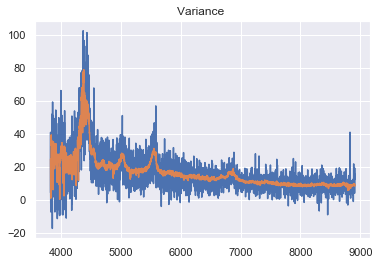

In [12]:
print((noise[856]))
keepidx, = np.where((wave[856] > 3.5818) & (wave[856] < 3.95))

plt.plot(10**wave[856][keepidx], flux[856][keepidx])
plt.plot(10**wave[856][keepidx], flux[856][keepidx] - deviate[856][keepidx])
plt.title('Variance ')

variance, scaled variance, original spectrum, scaled spectrum, std vs 

In [13]:
fake_dict = merg_dict(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,\
                     x21, x22, x23, x24)

In [14]:
upd_fake = calc_model_noise(fake_dict)

In [15]:
bal_fake = balancing_noise(upd_fake, var_star_dict['LOW'], 35)

In [16]:
new_noise = np.asarray(bal_fake['FAKE_NOISE'])
new_norm_noise = np.asarray(bal_fake['NOISE'])
new_wave = np.asarray(bal_fake['WAVE'])
new_redshift = np.asarray(bal_fake['REDSHIFT'])
new_flux = np.asarray(bal_fake['FLUX'])
new_class = np.asarray(bal_fake['CLASS'])

redshift_indx0 = np.where((new_redshift >= 2.45) & (new_redshift < 2.50))
redshift_indx1 = np.where((new_redshift >= 2.50) & (new_redshift < 2.55))
redshift_indx2 = np.where((new_redshift >= 2.55) & (new_redshift < 2.60))
redshift_indx3 = np.where((new_redshift >= 2.60) & (new_redshift < 2.65))
redshift_indx4 = np.where((new_redshift >= 2.65) & (new_redshift < 2.7))
redshift_indx5 = np.where((new_redshift >= 2.7) & (new_redshift < 2.75))
redshift_indx6 = np.where((new_redshift >= 2.75) & (new_redshift < 2.8))
redshift_indx7 = np.where((new_redshift >= 2.8) & (new_redshift < 2.85))
redshift_indx8 = np.where((new_redshift >= 2.85) & (new_redshift < 2.9))
redshift_indx9 = np.where((new_redshift >= 2.9) & (new_redshift < 2.95))
redshift_indx10 = np.where((new_redshift >= 2.95) & (new_redshift < 3.0))
redshift_indx11 = np.where((new_redshift >= 3.0) & (new_redshift <= 3.05))


new_indx = np.concatenate((redshift_indx0[0][:280], redshift_indx1[0][:230], redshift_indx2[0][:250],\
                           redshift_indx3[0][:250],\
                         redshift_indx4[0], redshift_indx5[0], redshift_indx6[0], redshift_indx7[0][:205],redshift_indx8[0],
                          redshift_indx9[0],redshift_indx10[0],  redshift_indx11[0]))

In [17]:
cut_fake = {'FAKE_NOISE': new_noise[new_indx], 'NOISE': new_norm_noise[new_indx], 'WAVE': new_wave[new_indx],\
            'REDSHIFT': new_redshift[new_indx], 'FLUX': new_flux[new_indx], 'CLASS': new_class[new_indx]}

In [18]:
save_as_pickled_object(cut_fake, "/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/object_dict/fake_dict")


In [19]:
class_labels = np.asarray(var_star_dict['LOW']['CLASS'])
arr_indx = np.where(class_labels == 'QSO')
quasar_noise = np.asarray(var_star_dict['LOW']['NOISE'])
quasar_redshift = np.asarray(var_star_dict['LOW']['REDSHIFT'])

print(len(cut_fake['FAKE_NOISE']))
print(len(quasar_noise[arr_indx]))

2449
2459


(0, 400)

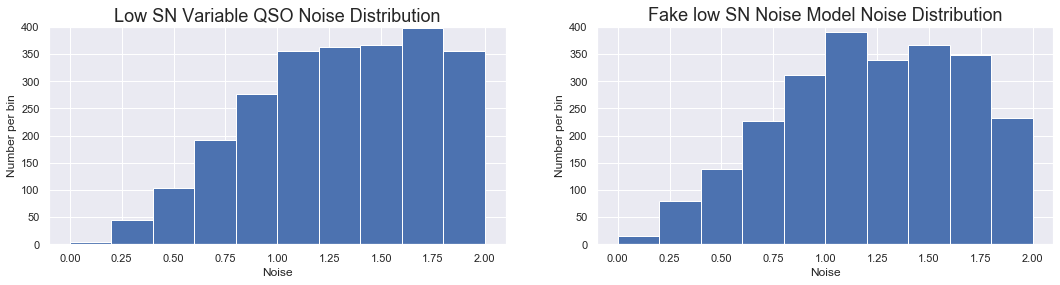

In [20]:
bin_list = [0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
ax1.hist(quasar_noise[arr_indx], bins = bin_list);
ax1.set_title('Low SN Variable QSO Noise Distribution', fontsize=18);
ax1.set_xlabel('Noise')
ax1.set_ylabel('Number per bin')
ax1.set_ylim(0,400)

ax2.hist(np.asarray(cut_fake['FAKE_NOISE']), bins = bin_list)
ax2.set_title('Fake low SN Noise Model Noise Distribution', fontsize=18);
ax2.set_xlabel('Noise')
ax2.set_ylabel('Number per bin')
ax2.set_ylim(0,400)

(0, 400)

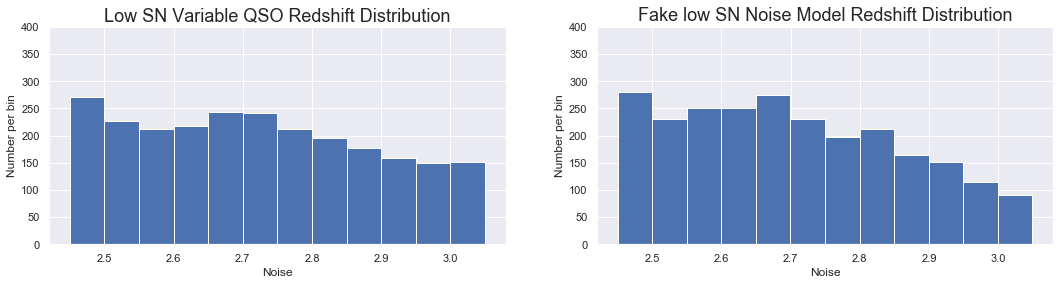

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
ax1.hist(quasar_redshift[arr_indx], bins = 12);
ax1.set_title('Low SN Variable QSO Redshift Distribution', fontsize=18);
ax1.set_xlabel('Noise')
ax1.set_ylabel('Number per bin')
ax1.set_ylim(0,400)
#ax1.set_xlim(2.7,3.05)

ax2.hist(np.asarray(cut_fake['REDSHIFT']), bins = 12)
ax2.set_title('Fake low SN Noise Model Redshift Distribution', fontsize=18);
ax2.set_xlabel('Noise')
ax2.set_ylabel('Number per bin')
ax2.set_ylim(0,400)
#ax2.set_xlim(2.7,3.05)

# Star Data

In [22]:
def calc_star_model_noise(merg_dict):
    """
    Code calculates the changed noise via the noise model
    """
        
    labels = merg_dict['CLASS']
    new_noise = []
    
    for i in range(len(labels)):
    
        if labels[i] == 'STAR':
        
            new_noise.append(np.mean(merg_dict['FLUX'][i])\
                     /(np.std(merg_dict['FLUX'][i])))      
            
    merg_dict['FAKE_NOISE'] = new_noise
    
    
    return merg_dict

def star_merg_dict(dict1, dict2,dict3,dict4):
    """This code merges dictionaries together that all have the same keys and assigns them to a new dictionary"""
    
    dict_list = [dict1, dict2, dict3, dict4]
    merged_dict = {}
    for k in dict1.keys():
        merged_dict[k] = np.concatenate(list(merged_dict[k] for merged_dict in dict_list))
        
    return merged_dict

In [23]:
star_perf_dict = perfect_SN(star_dict)

print(star_perf_dict.keys())
print(len(star_perf_dict['NOISE']))

dict_keys(['NOISE', 'FLUX', 'WAVE', 'IVAR', 'REDSHIFT', 'CLASS'])
8483


In [24]:
star_noise_model0 = noise_model(star_perf_dict, 0, 0.0)
star_noise_model1 = noise_model(star_perf_dict, 1, 0.0)
star_noise_model2 = noise_model(star_perf_dict, 2, 0.0)
star_noise_model3 = noise_model(star_perf_dict, 3, 0.0)


/Users/matt/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


In [25]:
star_merg = star_merg_dict(star_noise_model0, star_noise_model1, star_noise_model2, star_noise_model3)

In [26]:
upd_star = calc_star_model_noise(star_merg)

In [27]:
star_bal = balancing_noise(upd_star, var_star_dict['LOW'], 0 )

In [28]:
save_as_pickled_object(star_bal, "/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/object_dict/fake_star_dict")


In [29]:
print(len(star_bal['FAKE_NOISE']))

2459


In [30]:
class_labels = np.asarray(var_star_dict['LOW']['CLASS'])
arr_indx = np.where(class_labels == 'QSO')
quasar_noise = np.asarray(var_star_dict['LOW']['NOISE'])
quasar_redshift = np.asarray(var_star_dict['LOW']['REDSHIFT'])

indx0 = np.where((quasar_redshift >= 2.45) & (quasar_redshift < 2.50))
indx1 = np.where((quasar_redshift >= 2.50) & (quasar_redshift < 2.55))
indx2 = np.where((quasar_redshift >= 2.55) & (quasar_redshift < 2.60))
indx3 = np.where((quasar_redshift >= 2.60) & (quasar_redshift < 2.65))
indx4 = np.where((quasar_redshift >= 2.65) & (quasar_redshift < 2.7))
indx5 = np.where((quasar_redshift >= 2.7) & (quasar_redshift < 2.75))
indx6 = np.where((quasar_redshift >= 2.75) & (quasar_redshift < 2.8))
indx7 = np.where((quasar_redshift >= 2.8) & (quasar_redshift < 2.85))
indx8 = np.where((quasar_redshift >= 2.85) & (quasar_redshift < 2.9))
indx9 = np.where((quasar_redshift >= 2.9) & (quasar_redshift < 2.95))
indx10 = np.where((quasar_redshift >= 2.95) & (quasar_redshift < 3.0))
indx11 = np.where((quasar_redshift >= 3.0) & (quasar_redshift <= 3.05))

(0, 320)

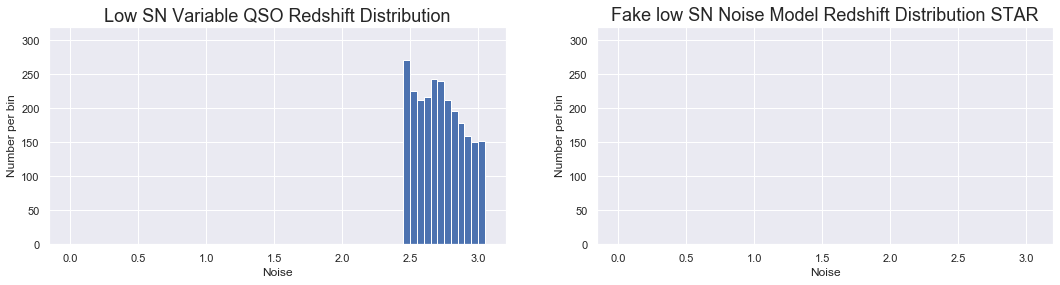

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
ax1.hist(quasar_redshift[arr_indx], bins = 12);
ax1.set_title('Low SN Variable QSO Redshift Distribution', fontsize=18);
ax1.set_xlabel('Noise')
ax1.set_ylabel('Number per bin')
ax1.set_ylim(0,320)

ax2.hist(np.asarray(star_bal['REDSHIFT']), bins = 12)
ax2.set_title('Fake low SN Noise Model Redshift Distribution STAR', fontsize=18);
ax2.set_xlabel('Noise')
ax2.set_ylabel('Number per bin')
ax2.set_ylim(0,320)

(0, 400)

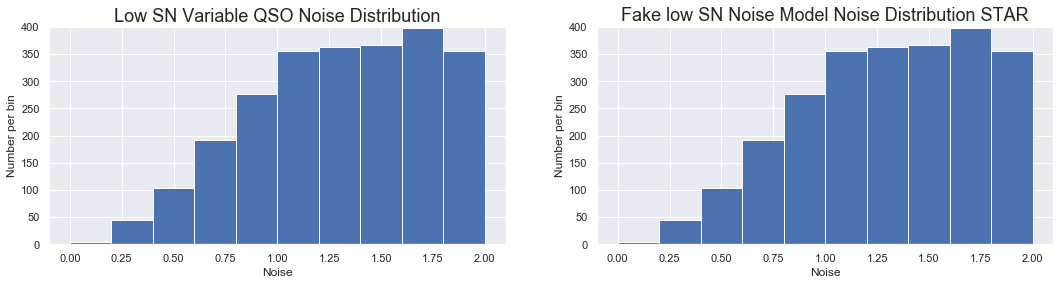

In [32]:
bin_list = [0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
ax1.hist(quasar_noise[arr_indx], bins = bin_list);
ax1.set_title('Low SN Variable QSO Noise Distribution', fontsize=18);
ax1.set_xlabel('Noise')
ax1.set_ylabel('Number per bin')
ax1.set_ylim(0,400)

ax2.hist(np.asarray(star_bal['FAKE_NOISE']), bins = bin_list)
ax2.set_title('Fake low SN Noise Model Noise Distribution STAR', fontsize=18);
ax2.set_xlabel('Noise')
ax2.set_ylabel('Number per bin')
ax2.set_ylim(0,400)

In [33]:
print(len(quasar_noise[arr_indx]))
print(len(new_noise[new_indx]))

2459
2449


In [34]:
noise_indx0 = np.where((new_noise >= 0.0) & (new_noise < 0.2))
noise_indx1 = np.where((new_noise >= 0.2) & (new_noise < 0.4))
noise_indx2 = np.where((new_noise >= 0.4) & (new_noise < 0.6))
noise_indx3 = np.where((new_noise >= 0.6) & (new_noise < 0.8))
noise_indx4 = np.where((new_noise >= 0.8) & (new_noise < 1.0))
noise_indx5 = np.where((new_noise >= 1.0) & (new_noise < 1.2))
noise_indx6 = np.where((new_noise >= 1.2) & (new_noise < 1.4))
noise_indx7 = np.where((new_noise >= 1.4) & (new_noise < 1.6))
noise_indx8 = np.where((new_noise >= 1.6) & (new_noise < 1.8))
noise_indx9 = np.where((new_noise >= 1.8) & (new_noise <= 2.0))

In [35]:
#redshift_bal_fake = balancing_fake_redshift(bal_fake, var_star_dict, 0)

In [36]:
#redshift_bal_fake.keys()

In [37]:
# class_labels = np.asarray(var_star_dict['LOW']['CLASS'])
# quasar_noise = np.asarray(var_star_dict['LOW']['NOISE'])
# quasar_redshift = np.asarray(var_star_dict['LOW']['REDSHIFT'])

# arr_indx = np.where(class_labels == 'QSO')



# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
# ax1.hist(quasar_redshift[arr_indx], bins = 10);
# ax1.set_title('Low SN Variable QSO Redshift Distribution', fontsize=18);
# ax1.set_xlabel('Noise')
# ax1.set_ylabel('Number per bin')
# ax1.set_ylim(0,400)

# ax2.hist(redshift_bal_fake['REDSHIFT'], bins = 10)
# ax2.set_title('Fake low SN Noise Model Redshift Distribution', fontsize=18);
# ax2.set_xlabel('Noise')
# ax2.set_ylabel('Number per bin')
# ax2.set_ylim(0,400)

In [38]:
# class_labels = np.asarray(var_star_dict['LOW']['CLASS'])
# quasar_noise = np.asarray(var_star_dict['LOW']['NOISE'])
# arr_indx = np.asarray(np.where(class_labels == 'QSO'))
# quasar_redshift = np.asarray(var_star_dict['LOW']['REDSHIFT'])

# bin_list = [0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.]


# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
# ax1.hist(quasar_noise[arr_indx], bins = bin_list);
# ax1.set_title('Low SN Variable QSO Noise Distribution', fontsize=18);
# ax1.set_xlabel('Noise')
# ax1.set_ylabel('Number per bin')
# ax1.set_ylim(0,450)

# ax2.hist(np.asarray(bal_fake['FAKE_NOISE']), bins = bin_list)
# ax2.set_title('Fake low SN Noise Model Noise Distribution', fontsize=18);
# ax2.set_xlabel('Noise')
# ax2.set_ylabel('Number per bin')
# ax2.set_ylim(0,450)